In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import os 
from time import time
import sys
from sklearn.model_selection import KFold, GroupKFold, train_test_split
import json
from numba import jit
import re

from abc import ABCMeta, abstractmethod
from pathlib import Path

import scipy
import random
from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
import pickle

# import modules
# sys.path.append('../utils/')
# from large_file_pickle import pickle_dump, pickle_load
# # from notifications import send_line_notification, notify_slack
# from memory_optimize import memory_reducer
# from util import *

import logging
import time
from typing import List, Optional, Union, Tuple, Dict
# from encoders import frequency_encoding
from contextlib import contextmanager

sys.path.append('../py/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 1000)


In [2]:
# comment to check reproducibility
# comment to check reproducibility2

# modules  



## utils

### util function


In [3]:
def groupings(df, cols, agg_dict, pref='') -> object:
    """
    Returns:
        object: 
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [pref + c[0] + "_" + c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace = True)
    
    return group_df

@contextmanager
def timer(name, logger=None):
    """時間計測
    """
    t0 = time.time()
    if logger:
        logger.log(logging.DEBUG, f'[{name}] start')
    else:
        print(f'[{name}] start')
    yield
    if logger:
        logger.log(logging.DEBUG, f'[{name}] done in {time.time() - t0:.0f} s')
    else:
        print(f'[{name}] done in {time.time() - t0:.0f} s')

def get_val_score(y_true, y_pred, obj="RMSE"):
    # RMSE
    if obj == "RMSE":
        val_score = np.sqrt(mean_squared_error(y_true, y_pred))
    elif obj == "QWK":
        val_score = qwk(y_true, y_pred, max_rat=3)
    else:
        raise ValueError("valuation is not defined!")
    return val_score

def memory_reducer(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        print(col)
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def applyParallel(dfGrouped, func):
    """関数の並列処理
    """
    retLst = Parallel(n_jobs=multiprocessing.cpu_count(), verbose=5)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)
        


### logs 

In [4]:
from lightgbm.callback import _format_eval_result

def log_evaluation(logger, period=100, show_stdv=True, level=logging.DEBUG):
    def _callback(env):
        if period > 0 and env.evaluation_result_list and (env.iteration + 1) % period == 0:
            result = '\t'.join([_format_eval_result(x, show_stdv) for x in env.evaluation_result_list])
            logger.log(level, '[{}]\t{}'.format(env.iteration + 1, result))

    _callback.order = 10
    return _callback

# ロガーの作成
# logging.basicConfig(level=logging.DEBUG)

def log_output(subject):
    logger = logging.getLogger('main')
    for h in logger.handlers:
        logger.removeHandler(h)

    logger.setLevel(logging.DEBUG)
    now = int(time.time())

    log_dir = os.path.join(os.path.dirname("__file__"), "../logs")
    os.makedirs(log_dir, exist_ok=True)

    log_path = Path(log_dir) / "{}_{}.log".format(subject, now)
    fh = logging.FileHandler(log_path)
    logger.addHandler(fh)

    return logger, log_path

### pickle files

In [5]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)

        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            # print(n, idx)
            batch_size = min(n - idx, 1 << 31 - 1)
            # print(batch_size)
            # print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            # print("done.", flush=True)
            idx += batch_size
        print("calculate done!")


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

## Feature class

In [6]:
class Features(metaclass=ABCMeta):

    def __init__(self, params, logger=None):
        self.name = self.__class__.__name__
        self.datatype = params["datatype"]
        self.debug = params["debug"]
        self.is_overwrite = params["is_overwrite"]
        self.org_columns = []
        self.logger = logger

        self.input_dir = os.path.join(os.path.dirname("__file__"), "../input")
        self.df_path = Path(self.input_dir) / f"{self.datatype}.csv"

        self.save_dir = os.path.join(os.path.dirname("__file__"), f"../feature")
        self.save_type_dir = Path(self.save_dir) / f"{self.datatype}"
        self.save_path = Path(self.save_type_dir) / f"{self.name}.pkl"
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.save_type_dir, exist_ok=True)

    def feature_extract(self, org_train, org_test):
        if self.check_feature_exec():
            with timer(f"FE: {self.name}", self.logger):
                a = self.calc_feature(org_train, org_test)
            return a

    @abstractmethod
    def calc_feature(self):
        """calc and save features
        Return: feature_df
        """
        raise NotImplementedError

    def format_and_save_feats(self, feat_df):
        """保存するカラムなど特徴量の形式を指定する
        """
        feat_cols = [c for c in list(feat_df.columns) if c not in self.org_columns]
        pickle_dump(feat_df[feat_cols], self.save_path)

        del feat_df
        gc.collect()

    def check_feature_exec(self):
        """
        すでに対象の特徴が存在するかどうかをcheckする
        Returns: bool (Falseなら特徴作成しない)

        """
        path = self.save_path

        if self.is_overwrite:
            print(f"overwrite features : {self.name}")
            return True
        else:
            if os.path.exists(path) is False:
                print(f"creates new file : {self.name}")
                return True

        print(f"file exists : {self.name}")
        return False


## model class


In [7]:
class LightGBM():
    def __init__(self, param):

        self.predict_type = param["predict_type"] # classifier, regressor
        self.train_params = param["train_params"]
        self.train_cols = param["train_cols"]
        self.cat_cols = param["cat_cols"]
        self.target = param["target"]
        self.is_debug = param["is_debug"]

    def train(self, train, valid, logger):
        if type(train) != pd.DataFrame or type(valid) != pd.DataFrame:
            raise ValueError('Parameter train and valid must be pandas.DataFrame')

        if list(train.columns) != list(valid.columns):
            raise ValueError('Train and valid must have a same column list')

        trn_x, trn_y = train[self.train_cols], train[self.target]
        val_x, val_y = valid[self.train_cols], valid[self.target]
        callbacks = [log_evaluation(logger, period=500)]
        
        if self.predict_type == "binary_classifier":
            clf = lgb.LGBMClassifier(**self.train_params)
            clf.fit(
                trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)],
                verbose=500,
                early_stopping_rounds=500,
                callbacks=callbacks,
                categorical_feature = self.cat_cols,
            )
            oof = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
            
        elif self.predict_type == "multi_classifier":
            clf = lgb.LGBMClassifier(**self.train_params)
            clf.fit(
                trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)],
                verbose=500,
                early_stopping_rounds=500,
                callbacks=callbacks,
                categorical_feature = self.cat_cols,
                eval_metric=eval_qwk_lgb
            )
            oof = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)

        elif self.predict_type == "regressor":
            clf = lgb.LGBMRegressor(**self.train_params)
            clf.fit(
                trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)],
                verbose=500,
                early_stopping_rounds=500,
                callbacks=callbacks,
                categorical_feature=self.cat_cols,
            )

            oof = clf.predict(val_x, num_iteration=clf.best_iteration_)

        else:
            raise ValueError("unknown prediction type !!")

        self.clf = clf

        # feature importance
        feature_importance_df = pd.DataFrame()
        feature_importance_df["feature"] = self.train_cols
        feature_importance_df["importance"] = self.clf.feature_importances_

        return clf, oof, feature_importance_df

    def predict(self, test, logger):
        if self.predict_type == "classifier":
            prediction = self.clf.predict_proba(test[self.train_cols],
                                                num_iteration=self.clf.best_iteration_)[:, 1]
        elif self.predict_type == "multi_classifier":
            prediction = self.clf.predict_proba(test[self.train_cols],
                                                num_iteration=self.clf.best_iteration_)
        elif self.predict_type == "regressor":
            prediction = self.clf.predict(test[self.train_cols],
                                          num_iteration=self.clf.best_iteration_)
        else:
            raise ValueError("unknown prediction type !!")

        return prediction

    def save_model(self, save_dir):
        pass

## validation

### QWK

In [8]:
@jit
def qwk(y_true, y_pred, max_rat= 3):
    y_true_ = np.asarray(y_true, dtype=int)
    y_pred_ = np.asarray(y_pred, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    numerator = 0
    for k in range(y_true_.shape[0]):
        i, j = y_true_[k], y_pred_[k]
        hist1[i] += 1
        hist2[j] += 1
        numerator += (i - j) * (i - j)

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator

def eval_qwk_lgb(y_true: Union[np.ndarray, list],
                           y_pred: Union[np.ndarray, list],) -> Tuple[str, float, bool]:
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", qwk(y_true, y_pred), True

### define validation class

In [9]:
class Validation():
    def __init__(self, validation_param, exp_conf, train, test, logger):
        self.model_name = validation_param["model_name"]
        self.train_small_dataset = exp_conf["train_small_dataset"]
#         self.common_conf = common_conf
        self.logger = logger
        self.exp_conf = exp_conf
        self.train = self.fix_train_size(train)
        self.test = test
        self.feature_importance = []

        self.logging_valid_parameters()

    def logging_valid_parameters(self):
#         self.logger.log(logging.DEBUG, self.common_conf)
        self.logger.log(logging.DEBUG, "[use_feature] " + "-" * 50)
        self.logger.log(logging.DEBUG, self.exp_conf["use_feature"])
        self.logger.log(logging.DEBUG, "[train_params] " + "-"*50)
        self.logger.log(logging.DEBUG, self.exp_conf["train_params"])

    def fix_train_size(self, train):
        if self.train_small_dataset:
            self.logger.log(logging.DEBUG, "Down-sampling train data.")
            self.logger.log(logging.DEBUG, f"Org-shape:{train.shape}")
            p = 0.15  # 学習に使用する割合
            np.random.seed(773)
            int_p = int(len(train.index.values) * p)
            sample_index = np.random.choice(train.index.values, int_p, replace=False)  # 重複なし

            train = train.loc[train.index.isin(sample_index)].reset_index(drop=True)
            self.logger.log(logging.DEBUG, f"sampled train-shape:{train.shape}")
            return train

        return train

    def generate_model(self, model_conf):
        if self.model_name == "LGBM":
            model = LightGBM(model_conf)
        else:
            raise ValueError("permitted models are [LGBM, ..., ]")
        return model

    def do_valid_kfold(self, model_conf, n_splits=5):
        sp = Splitter()
        target = model_conf["target"]
        split_x = self.train["installation_id"]
        split_y = self.train[target]
        seed = 773
        sp.get_kfold_idx(split_x, split_y, seed, n_cv=n_splits, stratified=False, group=True, pref=self.exp_conf["exp_name"])

        oof: ndarray = np.zeros((self.train.shape[0]))
        prediction = np.zeros((self.test.shape[0]))

        clf_list = []

        self.logger.log(logging.DEBUG, "[train cols] " + "-"*50)
        self.logger.log(logging.DEBUG, model_conf["train_cols"])
        self.validation_scores = []

        for i, (trn_idx, val_idx) in enumerate(sp.idx_list):
            self.logger.log(logging.DEBUG, "-" * 60)
            self.logger.log(logging.DEBUG, f"start training: {i}")

            with timer(f"fold {i}", self.logger):
                train_df, valid_df = self.train.loc[trn_idx], self.train.loc[val_idx]
                model = self.generate_model(model_conf)
                clf, fold_oof, feature_importance_df = model.train(train_df, valid_df, self.logger)
#                 fold_oof_class = fold_oof.argmax(axis = 1)
                
                fold_prediction = model.predict(self.test, self.logger)
#                 fold_val_score = get_val_score(valid_df[target], fold_oof_class, "QWK")

                # calc validation score using best iteration
#                 self.validation_scores.append(fold_val_score)
#                 self.logger.log(logging.DEBUG, f"fold_val_score: {fold_val_score:,.5f}")
                
                clf_list.append(clf)
                oof[val_idx] = fold_oof

                prediction += fold_prediction / n_splits

                feature_importance_df["fold"] = i
                self.feature_importance.append(feature_importance_df)

#         self.logger.log(logging.DEBUG,
#                         f"Total Validation Score: {sum(self.validation_scores) / len(self.validation_scores):,.5f}")

        self.feature_importance = pd.concat(self.feature_importance, axis=0)

        return clf_list, oof, prediction, self.feature_importance

    def do_adversarial_valid_kfold(self, model_conf, n_splits=2):
        sp = Splitter()
        target = "is_test"
        split_x = self.train["installation_id"]
        split_y = self.train[target]
        seed = 773
        sp.get_kfold_idx(split_x, split_y, seed, n_cv=n_splits, stratified=True, pref="adv")

        target_length = 1
        oof: ndarray = np.zeros(self.train.shape[0])
        prediction = np.zeros(self.test.shape[0])

        clf_list = []

        self.logger.log(logging.DEBUG, "[train cols] " + "-"*50)
        self.logger.log(logging.DEBUG, model_conf["train_cols"])
        self.validation_scores = []

        for i, (trn_idx, val_idx) in enumerate(sp.idx_list):
            self.logger.log(logging.DEBUG, "-" * 60)
            self.logger.log(logging.DEBUG, f"start training: {i}")

            with timer(f"fold {i}", self.logger):
                train_df, valid_df = self.train.loc[trn_idx], self.train.loc[val_idx]
                model = self.generate_model(model_conf)
                clf, fold_oof, feature_importance_df = model.train(train_df, valid_df, self.logger)

                # calc validation score using clf.best_iteration_
                fold_val_score = get_val_score(valid_df[target], fold_oof)
                self.validation_scores.append(fold_val_score)
                self.logger.log(logging.DEBUG, f"fold_val_score: {fold_val_score:,.5f}")

                clf_list.append(clf)
                oof[val_idx] = fold_oof

                feature_importance_df["fold"] = i
                self.feature_importance.append(feature_importance_df)

        self.logger.log(logging.DEBUG,
                        f"Total Validation Score: {sum(self.validation_scores) / len(self.validation_scores):,.5f}")

        oof = np.expm1(oof)
        self.train["pred_y"] = oof
        self.feature_importance = pd.concat(self.feature_importance, axis=0)

        return clf_list, oof, prediction, self.feature_importance


class Splitter():
    def __init__(self):
        self.save_dir = os.path.join(os.path.dirname("__file__"), "../data/valid_idx")
        self.idx_list = []
        os.makedirs(self.save_dir, exist_ok=True)

    def get_kfold_idx(self, split_x, split_y, seed, n_cv=5, stratified=True, group=False, pref=""):
        if group is False:
            if stratified:
                self.folds = StratifiedKFold(n_splits=n_cv, shuffle=False, random_state=seed)
            else:
                self.folds = KFold(n_splits=n_cv, shuffle=True, random_state=seed)

            for i, (trn_, val_) in enumerate(self.folds.split(split_x, split_y)):
                self.idx_list.append([trn_, val_])
                idx_trn_path = os.path.join(self.save_dir, "trn_idx_{}{}_{}.npy".format(pref, i, seed))
                idx_val_path = os.path.join(self.save_dir, "val_idx_{}{}_{}.npy".format(pref, i, seed))
                np.save(idx_trn_path, trn_)
                np.save(idx_val_path, val_)

            return self.idx_list
    
        else:
            groups = split_x
            self.folds = GroupKFold(n_splits=n_cv)
            for i, (trn_, val_) in enumerate(self.folds.split(split_x, split_y, groups)):
                self.idx_list.append([trn_, val_])
                idx_trn_path = os.path.join(self.save_dir, "trn_idx_{}{}_{}.npy".format(pref, i, seed))
                idx_val_path = os.path.join(self.save_dir, "val_idx_{}{}_{}.npy".format(pref, i, seed))
                np.save(idx_trn_path, trn_)
                np.save(idx_val_path, val_)

            return self.idx_list                
        

class Validation2():
    def __init__(self, validation_param, exp_conf, train,
                 test, logger=None, another_train=None):
        self.model_name = validation_param["model_name"]
        self.train_small_dataset = exp_conf["train_small_dataset"]
        self.logger = logger
        self.exp_conf = exp_conf
        self.train = self.fix_train_size(train)
        self.test = test
        self.another_train = another_train
        if another_train:
            self.another_train_idx = np.arange(
                len(another_train)) + len(self.train)
            self.another_train.index = self.another_train_idx
        self.feature_importance = []

        self.logging_valid_parameters()

    def logging_valid_parameters(self):
        self.logger.log(logging.DEBUG, "[use_feature] " + "-" * 50)
        self.logger.log(logging.DEBUG, self.exp_conf["use_feature"])
        self.logger.log(logging.DEBUG, "[train_params] " + "-" * 50)
        self.logger.log(logging.DEBUG, self.exp_conf["train_params"])

    def fix_train_size(self, train):
        if self.train_small_dataset:
            self.logger.log(logging.DEBUG, "Down-sampling train data.")
            self.logger.log(logging.DEBUG, f"Org-shape:{train.shape}")
            p = 0.15  # 学習に使用する割合
            np.random.seed(773)
            int_p = int(len(train.index.values) * p)
            sample_index = np.random.choice(
                train.index.values, int_p, replace=False)  # 重複なし

            train = train.loc[train.index.isin(
                sample_index)].reset_index(drop=True)
            self.logger.log(logging.DEBUG,
                            f"sampled train-shape:{train.shape}")
            return train

        return train

    def generate_model(self, model_conf):
        if self.model_name == "LGBM":
            model = LightGBM(model_conf)
        else:
            raise ValueError("permitted models are [LGBM, ..., ]")
        return model

    def do_valid_kfold(self, model_conf, n_splits=5,
                       trn_mode='simple', val_mode='simple'):
        sp = Splitter()
        target = model_conf["target"]
        split_x = self.train["installation_id"]
        split_y = self.train[target]
        seed = 773
        sp.get_kfold_idx(
            split_x,
            split_y,
            seed,
            n_cv=n_splits,
            stratified=False,
            group=True,
            pref=self.exp_conf["exp_name"])

        oof: ndarray = np.zeros((self.train.shape[0]))
        labels = np.zeros((self.train.shape[0]))
        prediction = np.zeros((self.test.shape[0]))

        clf_list = []

        self.logger.log(logging.DEBUG, "[train cols] " + "-" * 50)
        self.logger.log(logging.DEBUG, model_conf["train_cols"])
        self.validation_scores = []

        for i, (trn_idx, val_idx) in enumerate(sp.idx_list):
            self.logger.log(logging.DEBUG, "-" * 60)
            self.logger.log(logging.DEBUG, f"start training: {i}")

            with timer(f"fold {i}", self.logger):
                _train = self.train.copy()
                if self.another_train:
                    _train = pd.concat([_train, self.another_train])
                    trn_idx = np.concatenate([trn_idx, self.another_train_idx])
                if trn_mode == 'simple':
                    pass
                elif trn_mode == 'last_truncated':
                    trn_idx = self.get_last_trancated_idx(_train, trn_idx)
                if val_mode == 'simple':
                    pass
                elif val_mode == 'last_truncated':
                    val_idx = self.get_last_trancated_idx(_train, val_idx)

                train_df, valid_df = _train.loc[trn_idx], _train.loc[val_idx]

                model = self.generate_model(model_conf)
                clf, fold_oof, feature_importance_df = model.train(
                    train_df, valid_df, self.logger)
#                 fold_oof_class = fold_oof.argmax(axis = 1)

                fold_prediction = model.predict(self.test, self.logger)
#                 fold_val_score = get_val_score(valid_df[target], fold_oof_class, "QWK")

                # calc validation score using best iteration
#                 self.validation_scores.append(fold_val_score)
#                 self.logger.log(logging.DEBUG, f"fold_val_score: {fold_val_score:,.5f}")

                clf_list.append(clf)
                oof[val_idx] = fold_oof
                labels[val_idx] = valid_df['accuracy_group'].values

                prediction += fold_prediction / n_splits

                feature_importance_df["fold"] = i
                self.feature_importance.append(feature_importance_df)

#         self.logger.log(logging.DEBUG,
# f"Total Validation Score: {sum(self.validation_scores) /
# len(self.validation_scores):,.5f}")

        self.feature_importance = pd.concat(self.feature_importance, axis=0)

        return clf_list, oof, prediction, self.feature_importance, labels

    def do_adversarial_valid_kfold(self, model_conf, n_splits=2):
        sp = Splitter()
        target = "is_test"
        split_x = self.train["installation_id"]
        split_y = self.train[target]
        seed = 773
        sp.get_kfold_idx(
            split_x,
            split_y,
            seed,
            n_cv=n_splits,
            stratified=True,
            pref="adv")

        target_length = 1
        oof: ndarray = np.zeros(self.train.shape[0])
        prediction = np.zeros(self.test.shape[0])

        clf_list = []

        self.logger.log(logging.DEBUG, "[train cols] " + "-" * 50)
        self.logger.log(logging.DEBUG, model_conf["train_cols"])
        self.validation_scores = []

        for i, (trn_idx, val_idx) in enumerate(sp.idx_list):
            self.logger.log(logging.DEBUG, "-" * 60)
            self.logger.log(logging.DEBUG, f"start training: {i}")

            with timer(f"fold {i}", self.logger):
                train_df, valid_df = self.train.loc[trn_idx], self.train.loc[val_idx]
                model = self.generate_model(model_conf)
                clf, fold_oof, feature_importance_df = model.train(
                    train_df, valid_df, self.logger)

                # calc validation score using clf.best_iteration_
                fold_val_score = get_val_score(valid_df[target], fold_oof)
                self.validation_scores.append(fold_val_score)
                self.logger.log(logging.DEBUG,
                                f"fold_val_score: {fold_val_score:,.5f}")

                clf_list.append(clf)
                oof[val_idx] = fold_oof

                feature_importance_df["fold"] = i
                self.feature_importance.append(feature_importance_df)

        self.logger.log(logging.DEBUG,
                        f"Total Validation Score: {sum(self.validation_scores) / len(self.validation_scores):,.5f}")

        oof = np.expm1(oof)
        self.train["pred_y"] = oof
        self.feature_importance = pd.concat(self.feature_importance, axis=0)

        return clf_list, oof, prediction, self.feature_importance

    def get_last_trancated_idx(self, df, idx):
        df = df.loc[idx]
        idx = df\
            .sort_values(['installation_id', 'bef_target_cnt'])\
            .drop_duplicates('installation_id', keep='last').index
        return idx

# feature engineering

## sample feature 

In [10]:
class sample_feature(Features):
    """sample feature
    """
    def __int__(self, params, logger):
        super().__init__(params, logger)

    def calc_feature(self, org_train, org_test):
        
        if self.datatype == "train":
            df = org_train
        else:
            df = org_test
            
        feat_df = df.groupby("installation_id")["title"].count().reset_index()
        self.format_and_save_feats(feat_df)
        
        return feat_df

## base kernel features

In [11]:
class KernelBasics(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def mapping_codes(self, org_train, org_test):
        self.all_activities = set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        
        # convert activities <=> int
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities)))) # activity title => int 
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities)) # int => activity title 
        
        # convert win_code <=> int 
        win_code = dict(
            zip(activities_map.values(),
                (4100 * np.ones(len(activities_map))).astype(int)))
        win_code[activities_map["Bird Measurer (Assessment)"]] = 4110
        
        self.win_code = win_code
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
        self.format_and_save_feats(ret)
        
        return ret
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # initialize user activity 
        # 1. time spent 
        # 2. event count 
        # 3. session count 
        
        # sessionごとのplaytimeを算出
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["gs_max_time", "game_session", "type"],  
                            columns="title", 
                            values="game_time", 
                            aggfunc="max").fillna(0)
        
        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)
        
        cum_cols = [c for c in list(pv.columns) if c not in ["type", "game_session", "gs_max_time"]]
        pv[cum_cols] = (pv[cum_cols].cumsum() // 1000).astype("int32")
        pv[cum_cols] = pv[cum_cols].shift(1) # 直前までのplaytimeを取得する
        
        ins_id = df.installation_id.values[0]
        
        # assessmentのrowに限定して抽出する
        if self.datatype == "train":
            # 正解ラベル/num_corrects を得るためtrain labelsとmerge
            pv = pd.merge(pv, self.train_labels[self.train_labels.installation_id == ins_id], how="inner", on="game_session")
        else:
            # calc num corrects 
            num_c_df = df.loc[df.type == "Assessment"].groupby(["installation_id","game_session"])[["num_correct", "num_incorrect"]].sum().fillna(0).reset_index()
            pv = pd.merge(pv, num_c_df, how="left", on="game_session")
            
        gc.collect()
        
        # 直前までの正解状況を集計
        pv["prev_num_corrects"] = pv["num_correct"].shift(1).fillna(0)
        pv["prev_cumnum_c"] = pv["prev_num_corrects"].cumsum()
        pv["prev_num_incorrects"] = pv["num_incorrect"].shift(1).fillna(0)
        pv["prev_cumnum_inc"] = pv["prev_num_incorrects"].cumsum()

        pv["cum_accuracy"] = (pv["prev_cumnum_c"] / 
                                     (pv["prev_cumnum_c"] + pv["prev_cumnum_inc"])).fillna(0)
        
        del pv["num_correct"], pv["num_incorrect"], pv["gs_max_time"], pv["prev_num_corrects"], pv["prev_num_incorrects"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv
    
    
class KernelBasics2(Features):
    """kernel features revised
    """

    def __init__(self, train_labels, params, logger=None):
        super().__init__(params, logger=logger)
        self.train_labels = train_labels

    def mapping_codes(self, org_train, org_test):
        self.all_activities = set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())

        # convert activities <=> int
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities))))  # activity title => int
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities))  # int => activity title

        # convert win_code <=> int
        win_code = dict(
            zip(activities_map.values(),
                (4100 * np.ones(len(activities_map))).astype(int)))
        win_code[activities_map["Bird Measurer (Assessment)"]] = 4110

        self.win_code = win_code

    def calc_feature(self, org_train, org_test):
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(
                self.train_labels.installation_id.unique())]
        else:
            df = org_test

        c_ass_idx = (((df.event_code == 4100)
                      & (df.title != "Bird Measurer (Assessment)")
                      & (df["event_data"].str.contains("true"))) |
                     ((df.event_code == 4110)
                      & (df.title == "Bird Measurer (Assessment)")
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100)
                        & (df.title != "Bird Measurer (Assessment)")
                        & (df["event_data"].str.contains("false"))) |
                       ((df.event_code == 4110)
                        & (df.title == "Bird Measurer (Assessment)")
                        & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1

        ret = applyParallel(
            df.groupby("installation_id"),
            self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy", "accuracy_group", "cum_accuracy",
                                                             "game_session", "installation_id", "title",
                                                             "type"
                                                             ]]

        use_cols = [c for c in list(ret.columns) if "Assessment" not in c]
        del ret["accum_acc_gr_-99"], ret["prev_acc_gr_-99"]

        fill_cols = [
            c for c in list(
                ret.columns) if c not in [
                "cum_accuracy",
                "cum_accuracy",
                "prev_num_corrects",
                "prev_num_incorrects"]]
        ret[fill_cols] = ret[fill_cols].fillna(0)

        if self.datatype == "train":
            ret = pd.merge(
                ret, self.train_labels, how="inner", on=[
                    "installation_id", "game_session"])

        self.format_and_save_feats(ret)

        return ret

    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id
        """
        # initialize user activity
        # 1. time spent
        # 2. event count
        # 3. session count

        # sessionごとのplaytimeを算出
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform(
            "max")  # gs_max_timeでsortする必要がある
        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],
                            columns="title",
                            values="game_time",
                            aggfunc="max").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)

        cum_cols = [
            c for c in list(
                pv.columns) if c not in [
                "installation_id",
                "type",
                "game_session",
                "gs_max_time"]]
#         pv[cum_cols] = (pv[cum_cols].cumsum() // 1000).astype("int32")
        pv[cum_cols] = (pv[cum_cols].cumsum()).fillna(0)
        pv[cum_cols] = pv[cum_cols].shift(1)  # 直前までのplaytimeを取得する

        ins_id = df.installation_id.values[0]
        # calc num corrects
        pv = pv.loc[pv.type == "Assessment"]
        num_c_df = df.loc[(df.type == "Assessment") &
                          ((df.num_correct > 0) | (df.num_incorrect > 0))].groupby(["game_session"])[["num_correct", "num_incorrect"]].sum().reset_index()
        pv = pd.merge(pv, num_c_df, how="left", on="game_session")

        if self.datatype == "test":
            last_session_name = pv.sort_values(
                "gs_max_time")["game_session"].values[-1]
        else:
            last_session_name = "train_dummy_session"

        # train labelsのsessionは(pv.num_correct > 0) | (pv.num_incorrect >
        # 0)を常に満たす
        pv = pv.loc[((pv.num_correct > 0) | (pv.num_incorrect > 0))
                    | (pv.game_session == last_session_name)]
        gc.collect()

        # 直前までの正解状況を集計
        pv["prev_num_corrects"] = pv["num_correct"].shift(1)
        pv["prev_num_incorrects"] = pv["num_incorrect"].shift(1)
        pv["prev_cumnum_c"] = pv["prev_num_corrects"].cumsum()
        pv["prev_cumnum_inc"] = pv["prev_num_incorrects"].cumsum()

        pv["cum_accuracy"] = (pv["prev_cumnum_c"] /
                              (pv["prev_cumnum_c"] + pv["prev_cumnum_inc"]))

        del pv["num_correct"], pv["num_incorrect"]
        gc.collect()

        pv = self.get_acc_group(pv)
        pv = pv.sort_values("gs_max_time").reset_index(drop=True)
        del pv["gs_max_time"]

        if self.datatype == "test":
            pv = pd.DataFrame([pv.iloc[-1, :]])
        return pv

    def get_acc_group(self, pv):
        def calc_accuracy_group(row):
            if row["prev_num_incorrects"] + row["prev_num_corrects"] > 0:
                acc = row["prev_num_corrects"] / \
                    (row["prev_num_incorrects"] + row["prev_num_corrects"])
                if acc == 0:
                    return 0
                elif acc == 1:
                    return 3
                elif acc == 0.5:
                    return 2
                else:
                    return 1
            else:
                return -99

        pv["acc_group"] = pv.apply(calc_accuracy_group, axis=1)
        acc_pv = pd.pivot_table(pv[["gs_max_time",
                                    "installation_id",
                                    "game_session",
                                    "acc_group"]],
                                index=["gs_max_time",
                                       "game_session"],
                                columns="acc_group",
                                values="installation_id",
                                aggfunc="count").reset_index().fillna(0)
        del pv["acc_group"]

        acc_columns = {}
        for col in acc_pv.columns:
            if col in [-99, 0, 1, 2, 3]:
                acc_columns[col] = "prev_acc_gr_" + str(col)
                acc_pv[f"accum_acc_gr_{col}"] = acc_pv[col].cumsum()

        acc_pv.rename(columns=acc_columns, inplace=True)
        del acc_pv["gs_max_time"]
        pv = pd.merge(pv, acc_pv, on="game_session", how="left")

        return pv

    def test_calc_feature(self, org_train, org_test):
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(
                self.train_labels.installation_id.unique())]
        else:
            df = org_test
#             df = org_train
#             df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]

        c_ass_idx = (((df.event_code == 4100)
                      & (df.title != "Bird Measurer (Assessment)")
                      & (df["event_data"].str.contains("true"))) |
                     ((df.event_code == 4110)
                      & (df.title == "Bird Measurer (Assessment)")
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100)
                        & (df.title != "Bird Measurer (Assessment)")
                        & (df["event_data"].str.contains("false"))) |
                       ((df.event_code == 4110)
                        & (df.title == "Bird Measurer (Assessment)")
                        & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1

        ins_df = df.loc[df.installation_id == "0006a69f"]
        pv = self.ins_id_sessions(ins_df)

        return pv

## EventCount

In [12]:
class EventCount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="event_code", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "type", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")
        
        pv = pv.loc[pv["type"] == "Assessment"] # assessment だけとればOK
        
        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = "ev_cnt" + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"], pv["type"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv
    
class EventCount2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        
        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="event_id", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "type", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")
        
        pv = pv.loc[pv["type"] == "Assessment"] # assessment だけとればOK
        
        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = "ev_cnt" + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"], pv["type"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv


## Worldcount

In [13]:
class Worldcount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
                            
        ret = applyParallel(df.groupby("installation_id"), self.count_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["game_session","installation_id","title","type"]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")

        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "event_code", "gs_max_time"]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def count_sessions(self, df):
        world_cnt = self.sub_count_sessions(df, ["world"], "wrd_cnt_")
        world_type_cnt = self.sub_count_sessions(df, ["world", "type"], "wrd_type_cnt_")        
        title_type_cnt = self.sub_count_sessions(df, ["title", "type"], "title_type_cnt_")
        
        world_cnt = pd.merge(world_cnt, world_type_cnt, how="left", on=["installation_id", "game_session"])
        del world_type_cnt
        
        world_cnt = pd.merge(world_cnt, title_type_cnt, how="left", on=["installation_id", "game_session"])
        del title_type_cnt        
        
        return world_cnt
    
    def sub_count_sessions(self, df, group_columns, prefix):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        assess_sessions = df[df.type == "Assessment"]["game_session"].unique()
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session"],  
                            columns=group_columns, 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)
        
        if len(group_columns) >= 2:
            pv.columns = [c[0] + "_" + c[1] for c in pv.columns] 
            pv.rename(columns={"installation_id_": "installation_id", 
                               "game_session_": "game_session", 
                               "gs_max_time_": "gs_max_time"
                              }, inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")


        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = prefix + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])
        elif self.datatype =="train":
            pv = pv.loc[pv.game_session.isin(assess_sessions)]

        return pv


## SessionTime

In [14]:
class SessionTime(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
                            
        ret = applyParallel(df.groupby("installation_id"), self.time_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "world",
                                                              "event_code", "gs_max_time", "timestamp_max", "timestamp_min"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def count_sessions(self, df):
        world_cnt = self.sub_count_sessions(df, ["world"], "wrd_cnt_")
        world_type_cnt = self.sub_count_sessions(df, ["world", "type"], "wrd_type_cnt_")        
        title_type_cnt = self.sub_count_sessions(df, ["title", "type"], "title_type_cnt_")
        
        world_cnt = pd.merge(world_cnt, world_type_cnt, how="left", on=["installation_id", "game_session"])
        del world_type_cnt
        
        world_cnt = pd.merge(world_cnt, title_type_cnt, how="left", on=["installation_id", "game_session"])
        del title_type_cnt        
        
        return world_cnt
    
    def time_sessions(self, ins_df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        agg_dict = {
            "timestamp" : ["max", "min"]
        }
        duration_df = groupings(ins_df, ["installation_id", "world", "type", "game_session"], agg_dict).sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        duration_df["prev_gs_duration"] = (duration_df["timestamp_max"] - duration_df["timestamp_min"]).shift(1).dt.total_seconds()
        duration_df["session_interval"] = (duration_df["timestamp_min"] - duration_df["timestamp_max"].shift(1)).dt.total_seconds()
        
        window = 25
        min_periods = 5
        for col in ["prev_gs_duration", "session_interval"]:
            duration_df[col + "rmean"] = duration_df[col].rolling(window=window, min_periods=min_periods).mean()
            duration_df[col + "rstd"] = duration_df[col].rolling(window=window, min_periods=min_periods).std()
            duration_df[col + "rmax"] = duration_df[col].rolling(window=window, min_periods=2).max()
            duration_df[col + "rmin"] = duration_df[col].rolling(window=window, min_periods=2).min()        
            
        duration_df = duration_df.loc[duration_df.type == "Assessment"]
        
        if self.datatype=="test":
            duration_df = pd.DataFrame([duration_df.iloc[-1, :]])

        return duration_df
    
    
class SessionTime2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
                            
        ret = applyParallel(df.groupby("installation_id"), self.time_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "world",
                                                              "event_code", "gs_max_time", "timestamp_max", "timestamp_min"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def time_sessions(self, ins_df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        ### session feature for all "type"
        agg_dict = {
            "timestamp" : ["max", "min"]
        }
        duration_df = groupings(ins_df, ["installation_id", "world", "type", "game_session"], agg_dict).sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        duration_df["prev_gs_duration"] = (duration_df["timestamp_max"] - duration_df["timestamp_min"]).shift(1).dt.total_seconds()
        duration_df["session_interval"] = (duration_df["timestamp_min"] - duration_df["timestamp_max"].shift(1)).dt.total_seconds()
        
        window = 5
        min_periods = 2
        for col in ["prev_gs_duration", "session_interval"]:
            duration_df[col + "rmean"] = duration_df[col].rolling(window=window, min_periods=min_periods).mean()
            duration_df[col + "rstd"] = duration_df[col].rolling(window=window, min_periods=min_periods).std()
            duration_df[col + "rmax"] = duration_df[col].rolling(window=window, min_periods=2).max()
            duration_df[col + "rmin"] = duration_df[col].rolling(window=window, min_periods=2).min()        
            
        duration_df = duration_df.loc[duration_df.type == "Assessment"]
        
        ### session feature for "assessments"        
        agg_dict = {
            "timestamp" : ["max", "min"]
        }
        ass_duration = groupings(ins_df, ["installation_id", "world", "type", "game_session"], agg_dict)
        ass_duration = ass_duration.loc[ass_duration.type == "Assessment"].sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        ass_duration["prev_ass_gs_duration"] = (ass_duration["timestamp_max"] - ass_duration["timestamp_min"]).shift(1).dt.total_seconds()
        ass_duration["ass_session_interval"] = (ass_duration["timestamp_min"] - ass_duration["timestamp_max"].shift(1)).dt.total_seconds()

        window = 5
        min_periods = 1
        for col in ["prev_ass_gs_duration", "ass_session_interval"]:
            ass_duration[col + "_rmean"] = ass_duration[col].rolling(window=window, min_periods=min_periods).mean()
            ass_duration[col + "_rstd"] = ass_duration[col].rolling(window=window, min_periods=min_periods).std()
            ass_duration[col + "_rmax"] = ass_duration[col].rolling(window=window, min_periods=1).max()
            ass_duration[col + "_rmin"] = ass_duration[col].rolling(window=window, min_periods=1).min()        
        
        ass_cols = [c for c in list(ass_duration.columns) if c not in ['installation_id', 'world', 'type','timestamp_max','timestamp_min']]
        
        duration_df = pd.merge(duration_df, ass_duration[ass_cols], how="left", on="game_session")
        
        if self.datatype=="test":
            duration_df = pd.DataFrame([duration_df.iloc[-1, :]])

        return duration_df    

## EncodingTitles

In [15]:
class EncodingTitles(Features):
    """Event count in only Assessments
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def get_encoder(self, org_train, org_test):
        self.all_activities = np.sort(list(set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))))
        # self.all_activities = set(org_train["title"].unique()).union(
        #     set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities))))
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities))
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        # get encodings informations
        self.get_encoder(org_train, org_test)
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["title_enc"] = df["title"].map(self.activities_map)
        df = df.loc[df.type=="Assessment"][["installation_id", "game_session", "title_enc"]].drop_duplicates().reset_index(drop=True)
        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])

        return df

## PrevAssessResult

In [16]:
class PrevAssessResult(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="title", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)


        assess_col = [c for c in list(pv.columns) if "Assessment" in c]
        pv = pv[assess_col]
        pv.reset_index(inplace=True)

        rename_dict = {}
        new_cols = []
        
        cnt_pref = "assess_cnt_"
        for c in assess_col:
            rename_dict[c] = cnt_pref + str(c)     

        pv = pv.loc[pv.type=="Assessment"].reset_index(drop=True)
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        pv[assess_col] = pv[assess_col].shift(1).fillna(0)
        pv.rename(columns=rename_dict, inplace=True)
        
        for c in assess_col:
            pv["accum" + cnt_pref + str(c)] = pv[cnt_pref + str(c)].cumsum()

        del pv["gs_max_time"], pv["type"]

        return pv

## PrevAssessAcc

In [17]:
def assess_history(gr_df):
    gr_df = gr_df.sort_values("gs_max_time", ascending=True)

    gr_df["as_acc_c_num"] = gr_df["num_correct"].cumsum()
    gr_df["as_acc_inc_num"] = gr_df["num_incorrect"].cumsum()
    gr_df["as_prev_acc"] = gr_df["num_correct"] / (gr_df["num_correct"] + gr_df["num_incorrect"])
    gr_df["as_cum_acc"] = gr_df["as_acc_c_num"] / (gr_df["as_acc_c_num"] + gr_df["as_acc_inc_num"])

    shift_col = ["num_correct", "num_incorrect", "as_acc_c_num", "as_acc_inc_num", "as_prev_acc", "as_cum_acc"]
    gr_df[shift_col] = gr_df[shift_col].shift(1).fillna(-99)

    return gr_df    

class PrevAssessAcc(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0)
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        
        c_ass_idx = ((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true")))

        inc_ass_idx = ((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false")))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1

        df["num_correct"].fillna(0, inplace=True)
        df["num_incorrect"].fillna(0, inplace=True)

        df = df.loc[(df.type =="Assessment")]
        
        df = df.groupby(["installation_id", "game_session", "gs_max_time", "title"])[["num_correct", "num_incorrect"]].sum().reset_index()
               
        df = df.groupby("title").apply(assess_history)
        df = df.sort_values("gs_max_time", ascending=True)

        del df["title"], df["gs_max_time"]
        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])
       
        return df
    


## PrevAssessAccByTitle

In [18]:
class PrevAssessAccByTitle(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0)
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        
        c_ass_idx = ((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true")))

        inc_ass_idx = ((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false")))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1

        df["num_correct"].fillna(0, inplace=True)
        df["num_incorrect"].fillna(0, inplace=True)

        df = df.loc[(df.type =="Assessment")]
        
        pv = pd.pivot_table(df, index=["installation_id", "game_session", "gs_max_time"], columns="title", values=["num_correct", "num_incorrect"], aggfunc="sum").reset_index().sort_values("gs_max_time")

        pv.columns = [c[0] + "_" + c[1] if c[1] != "" else c[0] for c in list(pv.columns)]
        pv_num_cols = [c for c in list(pv.columns) if "correct" in c]

        cum_cols = ["cum_" + c for c in pv_num_cols] # 累積列

        pv_cum_corr_cols = [c for c in cum_cols if "cum_num_correct_" in c] # correct 列のみ 
        pv_cum_incorr_cols = [c for c in cum_cols if "cum_num_incorrect_" in c] # incorrect 列
        pv_cum_acc_cols = ["cum_acc_" + re.sub('num_incorrect_', '', c) for c in pv_cum_incorr_cols]

        pv.reset_index(drop=True, inplace=True)

        pv[pv_num_cols] = pv[pv_num_cols].shift(1).fillna(0)
        pv[cum_cols] = pv[pv_num_cols].cumsum()

        pv[pv_cum_acc_cols] = pd.DataFrame(pv[pv_cum_corr_cols].values / (pv[pv_cum_corr_cols].values + pv[pv_cum_incorr_cols].values))

        del pv["gs_max_time"]
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])
       
        return pv
    

## GameDurMiss

In [19]:
def game_duration(val):
    val = json.loads(val)
    duration = val["duration"]
    g_misses = val["misses"]
    
    return [duration, g_misses]

def world_cum_duration_calc(world_df):
    # duration / missを抽出
    wg_df = world_df[(world_df.event_code == 2030) & (world_df.type=="Game")]
    du_miss = np.array(wg_df["event_data"].apply(game_duration).tolist())
    try:
        wg_df["duration"] = du_miss[:, 0]
        wg_df["misses"] = du_miss[:, 1]
    except:
        wg_df["duration"] = np.nan
        wg_df["misses"] = np.nan

    del du_miss

    aggs = {
        "duration": ["min", "mean", "max", "std", "count"],
        "misses": ["min", "mean", "max", "std"],
    }

    game_cums = groupings(wg_df, ["game_session", "gs_max_time", "world"], aggs, "g_")

    del wg_df
    gc.collect()

    # 累積を計算
    game_cums = game_cums.sort_values("gs_max_time").reset_index(drop=True)

    num_cols = [c for c in list(game_cums.columns) if c not in ["game_session", "gs_max_time", "world"] ]
    cum_mean_cols = ["mean_" + c for c in num_cols]

    game_cums[cum_mean_cols] = game_cums[num_cols].cumsum()
    game_cums["cumnum"] = (game_cums.index + 1).values
    game_cums[cum_mean_cols] /= game_cums["cumnum"].values.reshape((-1, 1))

    game_cums[["game_session", "gs_max_time", "world"] + cum_mean_cols]

    # 直前のgameまでの累積結果をmergeする
    game_ass_uni = world_df[["world", "game_session", "type", "installation_id","gs_max_time"]].drop_duplicates().sort_values("gs_max_time").reset_index(drop=True)

    game_ass_uni = pd.merge(game_ass_uni, game_cums, how="left", on=["game_session", "gs_max_time", "world"]).fillna(method="ffill")
    game_ass_uni = game_ass_uni.loc[game_ass_uni.type=="Assessment"]

    return game_ass_uni

class GameDurMiss(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        gs_game_ass = df.loc[((df.event_code == 2030) & (df.type=="Game")) | (df.type=="Assessment")]
        gs_game_ass["gs_max_time"] = gs_game_ass.groupby("game_session")["timestamp"].transform("max")        
        
        game_ass_uni = gs_game_ass.groupby("world").apply(world_cum_duration_calc).reset_index(drop=True).sort_values("gs_max_time")
        
        del gs_game_ass
        
        if self.datatype=="test":
            game_ass_uni = pd.DataFrame([game_ass_uni.iloc[-1, :]])
       
        return game_ass_uni


## shift features

In [20]:
class immediatelyBeforeFeatures(Features):
    """
    date features
    """

    def __init__(self, train_labels, params, logger=None):
        super().__init__(params, logger=logger)
        self.train_labels = train_labels

    def get_encoder(self, org_train, org_test):
        self.all_activities = np.sort(list(set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))))
        self.all_event_codes = np.sort(list(set(org_train["event_code"].unique()).union(
            set(org_test["event_code"].unique()))))
        # self.all_activities = set(org_train["title"].unique()).union(
        #     set(org_test["title"].unique()))
        # self.all_event_codes = set(org_train["event_code"].unique()).union(
        #     org_test["event_code"].unique())
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities))))
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities))

    def calc_feature(self, org_train, org_test):
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(
                self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test

        # get encodings informations
        self.get_encoder(org_train, org_test)

        ret = applyParallel(
            df.groupby("installation_id"),
            self._calc_features)

        self.format_and_save_feats(ret)

        return ret

    def _calc_features(self, df):
        """
        """
        SHIFT = 1

        # game session 毎に feature を作る
        df = df.sort_values(['game_session', 'timestamp'])\
            .reset_index(drop=True)
        grp_features_df = df.groupby(['installation_id', 'game_session']).agg(
            {
                'timestamp': ['max', ],
                'event_count': ['max'],
                'event_code': {
                    'last': lambda x: x.iloc[-1]
                },
                'game_time': {
                    'max': 'max',
                    'skew': 'skew',
                    'kurt': lambda x: x.kurt(),
#                    'diff_mean': lambda x: x.diff().mean(),
#                    'diff_std': lambda x: x.diff().std()
#                    'diff_skew': lambda x: x.diff().skew()
#                    'diff_kurt': lambda x: x.diff().kurt()
                },
                'title': {
                    'LE': lambda x: self.activities_map[x.iloc[-1]],
                },
                'type': {
                    'LE': lambda x: {
                        'Game': 0,
                        'Activity': 1,
                        'Assessment': 2,
                        'Clip': 3,
                    }[x.iloc[-1]]
                },
                'world': {
                    'LE': lambda x: {
                        'MAGMAPEAK': 0,
                        'TREETOPCITY': 1,
                        'CRYSTALCAVES': 2,
                        'NONE': 3,
                    }[x.iloc[-1]]
                },
            }
        )
        # col 調整
        grp_features_df.columns = [
            f'{col[0]}_{col[1]}' for col in grp_features_df.columns]
        # session 順を保証
        grp_features_df = grp_features_df.sort_values('timestamp_max')
        grp_features_df = grp_features_df.drop('timestamp_max', axis=1)

        # shift
#            .set_index(['installation_id', 'game_session'])\
        res_grp_features_df = grp_features_df\
            .add_prefix(f'{SHIFT}th_before_session_')\
            .shift(SHIFT)\
            .reset_index()

        return res_grp_features_df

## world game numerical features

In [21]:
class worldGameNumeriacalFeatures(Features):
    def __init__(self, train_labels, params, logger=None):
        super().__init__(params, logger=logger)
        self.train_labels = train_labels

    def get_encoder(self, org_train, org_test):
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        self.inverse_activities_map = self.media_sequence.title.to_dict()
        self.activities_map = {v: k for k,
                               v in self.inverse_activities_map.items()}

    def calc_feature(self, org_train, org_test):
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(
                self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test

        c_ass_idx = ((df.type == "Game")
                     & (df["event_data"].str.contains("true"))) | \
            ((df.type == "Assesment")
             & (df["event_data"].str.contains("true")))

        inc_ass_idx = ((df.type == "Game")
                       & (df["event_data"].str.contains("false"))) | \
            ((df.type == "Assesment")
             & (df["event_data"].str.contains("false")))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1

        ret = applyParallel(
            df.groupby("installation_id"),
            self._calc_features)

        self.format_and_save_feats(ret)
        return ret

    def _calc_features(self, df):
        grp_df = df.groupby(['installation_id', 'game_session', 'world']).agg(
            {
                'timestamp': ['max', ],
                'num_correct': ['sum'],
                'num_incorrect': ['sum'],
                'game_time': ['max', 'std'],
                'event_count': ['max'],
            }
        )

        grp_df.columns = [
            f'{col[0]}_{col[1]}' for col in grp_df.columns]

        grp_df['accuracy'] = grp_df['num_correct_sum'] / \
            (grp_df['num_correct_sum'] + grp_df['num_incorrect_sum'])

        grp_df = grp_df.sort_values('timestamp_max')
        grp_df = grp_df.drop('timestamp_max', axis=1)
        grp_df = grp_df.shift(1)
        grp_df = grp_df.reset_index()

        res_df = grp_df[['installation_id', 'game_session']]

        for world in ['MAGMAPEAK', 'CRYSTALCAVES', 'TREETOPCITY', 'NONE']:
            _df = grp_df.copy()
            _df.loc[_df.world != world, 'accuracy'] = None

            res_df[f'{world}_accuracy_max'] = \
                _df['accuracy'].rolling(
                window=len(_df), min_periods=1).max()
            res_df[f'{world}_accuracy_min'] = \
                _df['accuracy'].rolling(
                window=len(_df), min_periods=1).min()
            res_df[f'{world}_accuracy_mean'] = \
                _df['accuracy'].rolling(
                window=len(_df), min_periods=1).mean()
            res_df[f'{world}_accuracy_std'] = \
                _df['accuracy'].rolling(
                window=len(_df), min_periods=1).std()
            res_df[f'{world}_just_before_accuracy'] = \
                _df['accuracy'].rolling(
                window=len(_df), min_periods=1).apply(
                lambda x: pd.Series(x).dropna().iloc[-1])

        worlds = ['MAGMAPEAK', 'CRYSTALCAVES', 'TREETOPCITY', 'NONE']
        res_df['world_accracy_mean_mean'] = res_df[[
            f'{world}_accuracy_mean' for world in worlds]].mean(axis=1).values
        res_df['world_accracy_mean_std'] = res_df[[
            f'{world}_accuracy_mean' for world in worlds]].std(axis=1).values
        res_df['world_accracy_max_max'] = res_df[[
            f'{world}_accuracy_max' for world in worlds]].max(axis=1).values
        res_df['world_accracy_max_mean'] = res_df[[
            f'{world}_accuracy_max' for world in worlds]].mean(axis=1).values
        res_df['world_accracy_max_std'] = res_df[[
            f'{world}_accuracy_max' for world in worlds]].std(axis=1).values
        res_df['world_accracy_min_min'] = res_df[[
            f'{world}_accuracy_min' for world in worlds]].min(axis=1).values
        res_df['world_accracy_min_mean'] = res_df[[
            f'{world}_accuracy_min' for world in worlds]].mean(axis=1).values
        res_df['world_accracy_min_std'] = res_df[[
            f'{world}_accuracy_min' for world in worlds]].std(axis=1).values
        res_df['world_accracy_std_mean'] = res_df[[
            f'{world}_accuracy_std' for world in worlds]].mean(axis=1).values
        res_df['world_accracy_std_std'] = res_df[[
            f'{world}_accuracy_std' for world in worlds]].std(axis=1).values

        if self.datatype == "test":
            res_df = pd.DataFrame([res_df.iloc[-1, :]])
        else:
            # to save memory
            res_df = res_df[
                res_df.game_session
                .isin(self.train_labels.game_session)
            ]

        res_df = res_df\
            .set_index(['installation_id', 'game_session'])\
            .add_prefix(f'worldwise_game_')\
            .reset_index()

        return res_df

## target count feature (need for truncated val!!)

In [22]:
class befTargetCntFeatures(Features):
    def __init__(self, train_labels, params, logger=None):
        super().__init__(params, logger=logger)
        self.train_labels = train_labels

    def calc_feature(self, org_train, org_test):
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(
                self.train_labels.installation_id.unique())]
        else:
            # $BD>A0$^$G$N(Bnum_correct/incorrect$B$r<hF@$9$k(B
            df = org_test

        ret = applyParallel(
            df.groupby("installation_id"),
            self._calc_features)

        self.format_and_save_feats(ret)
        return ret

    def _calc_features(self, df):
        df = df.sort_values('timestamp').reset_index(drop=True)
        df['test_last'] = 0
        if self.datatype == 'test':
            df.loc[df.shape[0]-1, 'test_last'] = 1

        df = df[
            ((df.type == 'Assessment')
             & (
                ((df.event_code == 4100)
                 & (df.title != 'Bird Measurer (Assessment)'))
                | ((df.event_code == 4110)
                   & (df.title == 'Bird Measurer (Assessment)'))
            ))
            | (df.test_last == 1)
        ]

        res_df = df.groupby(['installation_id', 'game_session']).agg(
            {
                'timestamp': ['max'],
            }
        )
        res_df.columns = [f'{col[0]}_{col[1]}' for col in res_df.columns]
        res_df = res_df.sort_values('timestamp_max')
        res_df['bef_target_cnt'] = res_df.rolling(
            window=len(res_df), min_periods=1).count().values
        res_df = res_df.drop(['timestamp_max'], axis=1)
        res_df = res_df.reset_index()

        if self.datatype == "test":
            res_df = pd.DataFrame([res_df.iloc[-1, :]])
        else:
            # to save memory
            res_df = res_df[
                res_df.game_session
                .isin(self.train_labels.game_session)
            ]

        return res_df

# Optimize Rounder

In [23]:
from functools import partial
import scipy as sp

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    
from functools import partial
import scipy as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error, cohen_kappa_score
class OptimizedRounder_v2(object):
    def __init__(self):
        self.coef_ = 0
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    def fit(self, X, y, method = 'nelder-mead'):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [1.0, 1.5, 2.0]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method=method)
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return preds
    def coefficients(self):
        return self.coef_['x']    

# preprocess 

## add features

In [24]:
def preprocess_dfs(use_features, is_local=False, logger=None, debug=True):
    # read dataframes     
    with timer("read datasets"):
        if debug: 
            nrows=200000 
        else: nrows=None
            
        sub = pd.read_csv(base_path + '/sample_submission.csv')
        
        if is_local:
            org_train = pickle_load("../input/train.pkl")
            org_test = pickle_load("../input/test.pkl")
        else:
            org_train = pd.read_csv(base_path + "/train.csv", nrows=nrows)
            org_test = pd.read_csv(base_path + "/test.csv", nrows=nrows)
            
        org_train = memory_reducer(org_train, verbose=True)
        org_test = org_test[org_test.installation_id.isin(sub.installation_id)]
        org_test.sort_values(['installation_id', 'timestamp'], inplace=True)
        org_test.reset_index(inplace=True)
        org_test = memory_reducer(org_test, verbose=True)
        
        train_labels = pd.read_csv(base_path + "/train_labels.csv", nrows=nrows)
        specs = pd.read_csv(base_path + "/specs.csv", nrows=nrows)

    # basic preprocess
    org_train["timestamp"] = pd.to_datetime(org_train["timestamp"])
    org_test["timestamp"] = pd.to_datetime(org_test["timestamp"])
    
    with timer("merging features"):
        train_df = add_features(use_features, org_train, org_test, train_labels, specs, datatype="train", is_local=is_local, logger=None)
        train_df = train_df.reset_index(drop=True)
        test_df = add_features(use_features, org_train, org_test, train_labels, specs, datatype="test", is_local=is_local, logger=None)
        test_df = test_df.reset_index(drop=True)
    
#     df = pd.concat([df, feat_df], axis=1)
    print("preprocess done!!")

    return train_df, test_df


def feature_maker(feat_cls, is_overwrite, org_train, org_test, train_labels, params, logger, is_local):
    """featureの読み込み
    """
    feat_ = feat_cls(train_labels, params, logger)
    feat_name = feat_.name
    datatype = feat_.datatype
    feature_dir = os.path.join(os.path.dirname("__file__"), "../feature")
    feature_path = Path(feature_dir) / f"{datatype}" / f"{feat_name}.pkl"
    
    if os.path.exists(feature_path) and is_overwrite is False:
        f_df = pickle_load(feature_path)
    else:
        f_df = feat_.feature_extract(org_train, org_test)
    
    return f_df


def add_features(use_features, org_train, org_test, train_labels, specs, datatype, is_local=False, logger=None):
    # 都度計算する
    feat_params = {
        "datatype": datatype,
        "debug": True,
        "is_overwrite": True,
    }

    # base feature
    # kernel basics 2 にはバグがあるので、修正版の kernel basics 3 を使用する
    # base_feat = KernelBasics2(train_labels, feat_params, logger)
    base_feat = KernelBasics2(train_labels, feat_params, logger)    
    feature_dir = os.path.join(os.path.dirname("__file__"), "../feature")
    feature_path = Path(feature_dir) / f"{datatype}" / f"{base_feat.name}.pkl"
    
    if os.path.exists(feature_path):
        feat_df = pickle_load(feature_path)
    else:
        feat_df = base_feat.feature_extract(org_train, org_test)

    # add event_counts
    for name, feat_condition in use_features.items():
        feat_cls = feat_condition[0]
        is_overwrite = feat_condition[1]
        
        f_df = feature_maker(feat_cls, is_overwrite, org_train, org_test, train_labels, feat_params, logger, is_local)
        feat_df = pd.merge(feat_df, f_df, how="left", on =["installation_id", "game_session"])
        del f_df

    return feat_df


# training


In [25]:
use_feature = {
    "befTargetCntFeatures": [befTargetCntFeatures, True], # MUST!!!!
    "immediatelyBeforeFeatures": [immediatelyBeforeFeatures, True],
###    "worldGameNumeriacalFeatures": [worldGameNumeriacalFeatures, True],
    "EventCount": [EventCount, True], # class, is_overwrite
    "EventCount2": [EventCount2, True], # class, is_overwrite
    "Worldcount": [Worldcount, True],
    "SessionTime": [SessionTime2, True],
####     "AssessEventCount": [AssessEventCount, False],
    "EncodingTitles": [EncodingTitles, True],
    "PrevAssessResult":[PrevAssessResult, True],
    "PrevAssessAcc": [PrevAssessAcc, True],
    "PrevAssessAccByTitle": [PrevAssessAccByTitle, True],
    "GameDurMiss": [GameDurMiss, False],
}

is_local = False

if is_local:
    base_path = "../input" # at local
    train_df, test_df = preprocess_dfs(use_feature, is_local=is_local, logger=None, debug=False)
    
else:
    sub = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')
    base_path = '/kaggle/input/data-science-bowl-2019' # at kaggle kernel
#    if len(sub)==1000:
    if False:
        sub.to_csv('submission.csv', index=False)
        exit(0)
    else:
        train_df, test_df = preprocess_dfs(use_feature, is_local=is_local, logger=None, debug=False)

[read datasets] start
event_id
game_session
timestamp
event_data
installation_id
event_count
event_code
game_time
title
type
world
Mem. usage decreased to 778.73 Mb (18.2% reduction)
index
event_id
game_session
timestamp
event_data
installation_id
event_count
event_code
game_time
title
type
world
Mem. usage decreased to 83.82 Mb (20.8% reduction)
[read datasets] done in 97 s
[merging features] start
overwrite features : KernelBasics2
[FE: KernelBasics2] start


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 15

writing total_bytes=9429562...
calculate done!
[FE: KernelBasics2] done in 377 s
overwrite features : befTargetCntFeatures
[FE: befTargetCntFeatures] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:   57.7s
[Parallel(n_jobs=4)]: Done 2892 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 3614 out of 3614 | elapsed:  1.5min finished


writing total_bytes=727821...
calculate done!
[FE: befTargetCntFeatures] done in 95 s
overwrite features : immediatelyBeforeFeatures
[FE: immediatelyBeforeFeatures] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   42.4s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:   57.5s
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 2170 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 3034 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 3614 out of 3614 | elapsed:  3.8min f

writing total_bytes=16840814...
calculate done!
[FE: immediatelyBeforeFeatures] done in 235 s
overwrite features : EventCount
[FE: EventCount] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:   44.3s
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:   57.8s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 2170 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 3034 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  3.3min
[P

writing total_bytes=4274932...
calculate done!
[FE: EventCount] done in 244 s
overwrite features : EventCount2
[FE: EventCount2] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   44.2s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 2170 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 3034 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  4.6min
[P

writing total_bytes=33082141...
calculate done!
[FE: EventCount2] done in 489 s
overwrite features : Worldcount
[FE: Worldcount] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   50.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 2170 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 3034 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  7.1min
[P

writing total_bytes=5890975...
calculate done!
[FE: Worldcount] done in 496 s
overwrite features : SessionTime2
[FE: SessionTime2] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   53.2s
[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 2892 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 3607 out of 3614 | elapsed:  2.5min remaining:    0.3s
[Parallel(n_jobs=4)]: Done 3614 out of 3614 | elapsed:  2.5min finished


writing total_bytes=3878080...
calculate done!
[FE: SessionTime2] done in 158 s
overwrite features : EncodingTitles
[FE: EncodingTitles] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   39.0s
[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:   52.8s
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 2892 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 4242 out of 4242 | elapsed:  2.1min finished


writing total_bytes=873681...
calculate done!
[FE: EncodingTitles] done in 132 s
overwrite features : PrevAssessResult
[FE: PrevAssessResult] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   38.3s
[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 2892 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 4242 out of 4242 | elapsed:  2.0min finished


writing total_bytes=1556161...
calculate done!
[FE: PrevAssessResult] done in 138 s
overwrite features : PrevAssessAcc
[FE: PrevAssessAcc] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   57.2s
[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 2892 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 4242 out of 4242 | elapsed:  3.0min finished


writing total_bytes=1850185...
calculate done!
[FE: PrevAssessAcc] done in 186 s
overwrite features : PrevAssessAccByTitle
[FE: PrevAssessAccByTitle] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   55.3s
[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 2892 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 3607 out of 3614 | elapsed:  2.5min remaining:    0.3s
[Parallel(n_jobs=4)]: Done 3614 out of 3614 | elapsed:  2.5min finished


writing total_bytes=4685430...
calculate done!
[FE: PrevAssessAccByTitle] done in 175 s
overwrite features : GameDurMiss
[FE: GameDurMiss] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 2170 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 3034 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 3614 out of 3614 | elapsed:  6.7min f

writing total_bytes=3881720...
calculate done!
[FE: GameDurMiss] done in 405 s
overwrite features : KernelBasics2
[FE: KernelBasics2] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.9s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   52.8s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.3min finished


writing total_bytes=509659...
calculate done!
[FE: KernelBasics2] done in 96 s
overwrite features : befTargetCntFeatures
[FE: befTargetCntFeatures] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   23.7s finished


writing total_bytes=46935...
calculate done!
[FE: befTargetCntFeatures] done in 24 s
overwrite features : immediatelyBeforeFeatures
[FE: immediatelyBeforeFeatures] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   41.1s finished


writing total_bytes=2722700...
calculate done!
[FE: immediatelyBeforeFeatures] done in 43 s
overwrite features : EventCount
[FE: EventCount] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   35.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   40.7s finished


writing total_bytes=207517...
calculate done!
[FE: EventCount] done in 50 s
overwrite features : EventCount2
[FE: EventCount2] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:   57.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.1min finished


writing total_bytes=1506290...
calculate done!
[FE: EventCount2] done in 107 s
overwrite features : Worldcount
[FE: Worldcount] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.7min finished


writing total_bytes=285396...
calculate done!
[FE: Worldcount] done in 112 s
overwrite features : SessionTime2
[FE: SessionTime2] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   41.4s finished


writing total_bytes=199462...
calculate done!
[FE: SessionTime2] done in 42 s
overwrite features : EncodingTitles
[FE: EncodingTitles] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   28.5s finished


writing total_bytes=46894...
calculate done!
[FE: EncodingTitles] done in 33 s
overwrite features : PrevAssessResult
[FE: PrevAssessResult] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   27.3s finished


writing total_bytes=248341...
calculate done!
[FE: PrevAssessResult] done in 33 s
overwrite features : PrevAssessAcc
[FE: PrevAssessAcc] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   33.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   39.0s finished


writing total_bytes=94157...
calculate done!
[FE: PrevAssessAcc] done in 39 s
overwrite features : PrevAssessAccByTitle
[FE: PrevAssessAccByTitle] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   37.0s finished


writing total_bytes=240252...
calculate done!
[FE: PrevAssessAccByTitle] done in 41 s
overwrite features : GameDurMiss
[FE: GameDurMiss] start


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   27.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   41.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.6min finished


writing total_bytes=205264...
calculate done!
[FE: GameDurMiss] done in 95 s
[merging features] done in 3847 s
preprocess done!!


In [26]:
train_df.columns = [col.replace(',', '_') for col in train_df.columns]
test_df.columns = [col.replace(',', '_') for col in test_df.columns]

## set configs

In [27]:
exp_name = "suga_001_add_eventidcnt"
logger, log_path = log_output(exp_name)

train_small_dataset = False
is_debug = True

# train_params = {
#     'learning_rate': 0.01,
#     'bagging_fraction': 0.90,
#     'feature_fraction': 0.85,
#     'max_depth': 5,
#     'lambda_l1': 0.7,
#     'lambda_l2': 0.7,
#     'metric': 'multiclass',
#     'objective': 'multiclass',
#     'num_classes': 4,
#     'random_state': 773,
#     "n_estimators": 3000    

# }

train_params = {
     'learning_rate': 0.01,
     'boosting_type': 'gbdt',
     'objective': 'regression',
     'metric': 'rmse',
    'num_leaves':  64,
     'bagging_fraction': 0.9,
     'bagging_freq': 1,
     'feature_fraction': 0.7,
     'max_depth': -1,
     'lambda_l1': 0.2,
     'lambda_l2': 0.4,    
     'seed': 19930802,
     'n_estimators': 100000,
     'importance_type': 'gain',
}

bad_feats = [
    'prev_gs_duration', 'session_intervalrmin', 'session_intervalrstd', 'session_intervalrmax', 'session_interval', 'accum_acc_gr_-99',
    'session_intervalrmean', 'ass_session_interval', 'prev_gs_durationrmean', 'prev_gs_durationrmax',
    'ev_cnt4070', 'prev_gs_durationrstd', 'mean_g_duration_meaan', 'ev_cnt3010', 'g_duration_std', 'ev_cnt4030', 'ev_cnt3110',
    'g_duration_mean', 'meaan_g_duration_min', 'ass_session_interval_rmin', 'accum_acc_gr_3', 'g_duration_min', 'mean_g_duraation_std'
]
no_use_cols = [
    "accuracy",
    "accuracy_group",
    "game_session",
    "installation_id",
    "title", 
    "type",
    "world",
    "pred_y",
    "bef_target_cnt",
] + list(set(train_df.columns) - set(test_df.columns)) + bad_feats


train_cols = [c for c in list(train_df.columns) if c not in no_use_cols]
    
print(f"train_df shape: {train_df.shape}")
print(train_cols)

cat_cols = [
            ]


# logger.log(logging.DEBUG, f"categorical cols: {cat_cols}")

target = "accuracy_group"

model_conf = {
    "predict_type": "regressor",
    "train_params": train_params,
    "train_cols": train_cols,
    "cat_cols": cat_cols,
    "target": target,
    "is_debug": is_debug,
}

validation_param = {
    "model_name": "LGBM",
}

exp_conf = {
    "train_small_dataset": False,
    "use_feature": {
        "sample": True
    },
    "train_params": train_params,
    "exp_name": exp_name
}

train_df shape: (17690, 640)
['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy_ Heavier_ Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!',

In [28]:
# v = Validation(validation_param, exp_conf, train_df, test_df, logger)
v = Validation2(validation_param, exp_conf, train_df, test_df, logger)
clf, oof, prediction, feature_importance, labels = v.do_valid_kfold(model_conf, trn_mode='simple',val_mode='last_truncated')

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.783603	valid_1's rmse: 1.05646
[1000]	training's rmse: 0.661252	valid_1's rmse: 1.05456
Early stopping, best iteration is:
[749]	training's rmse: 0.716765	valid_1's rmse: 1.05355
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.785333	valid_1's rmse: 1.01082
[1000]	training's rmse: 0.663471	valid_1's rmse: 1.01207
Early stopping, best iteration is:
[621]	training's rmse: 0.751318	valid_1's rmse: 1.009
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.785575	valid_1's rmse: 0.992599
[1000]	training's rmse: 0.663659	valid_1's rmse: 0.994672
Early stopping, best iteration is:
[705]	training's rmse: 0.730107	valid_1's rmse: 0.991569
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.778198	valid_1's rmse: 1.07199
[1000]	training's rmse: 0.657514	valid_1's rmse: 1.06749
[1500]	training's rmse: 0.

In [29]:
test_pred = prediction.copy()

In [30]:
# optR = OptimizedRounder()
optR = OptimizedRounder_v2()
#optR.fit(oof, train_df[target])
optR.fit(oof[oof != 0], labels[oof != 0])
coefficients = optR.coefficients()

opt_preds = optR.predict(oof[oof != 0], coefficients)
qwk(labels[oof != 0], opt_preds)


<ipython-input-8-3a0132078fe8>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "qwk" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-8-3a0132078fe8> (3)

File "<ipython-input-8-3a0132078fe8>", line 3:
def qwk(y_true, y_pred, max_rat= 3):
    y_true_ = np.asarray(y_true, dtype=int)
    ^

  @jit
<ipython-input-8-3a0132078fe8>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "qwk" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-8-3a0132078fe8>", line 10:
def qwk(y_true, y_pred, max_rat= 3):
    <source elided>
    numerator = 0
    for k in range(y_true_.shape[0]):
    ^

  @jit
/opt/conda/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "qwk" was compiled in object mode without forceobj=True, but has lifted loops.


0.5756972114699381

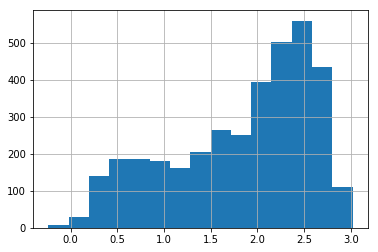

In [31]:
pd.Series(oof[oof != 0]).hist(bins=15)

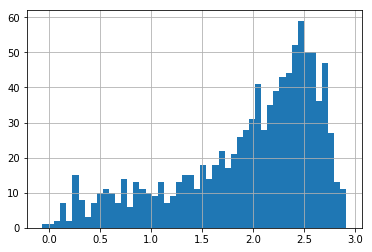

In [32]:
pd.Series(prediction).hist(bins=50)

In [33]:
coefficients

prediction = optR.predict(prediction, coefficients)

array([0.93194915, 1.61449192, 2.23388149])

In [34]:
feature_importance.groupby("feature")["importance"].mean().reset_index().sort_values("importance", ascending=False).head(50)

,feature,importance
531,title_enc,90306.082335
62,as_cum_acc,80120.110299
548,title_type_cnt_Crystal Caves - Level 3_Clip,34134.226344
63,as_prev_acc,23937.229863
77,cum_accuracy,23275.146126
52,accum_acc_gr_0,15938.241068
8,1th_before_session_world_LE,14040.329359
68,assess_cnt_Cart Balancer (Assessment),8292.671972
61,as_acc_inc_num,8250.427574
60,as_acc_c_num,8118.839789


In [35]:

sub_df =  pd.read_csv(base_path + "/sample_submission.csv")
# prediction.shape

In [36]:
sub_df["accuracy_group"] = prediction
# .argmax(axis = 1)
sub_df["accuracy_group"].value_counts(normalize=True)
sub_df.to_csv('submission.csv', index=False)

3    0.456
2    0.280
1    0.138
0    0.126
Name: accuracy_group, dtype: float64